# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

np.random.seed(1337)

In [3]:
# Load pickled data
import pickle

# fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((39209, 32, 32, 3), (39209,), (12630, 32, 32, 3), (12630,))

In [5]:
### To start off let's do a basic data summary.

# number of training examples
n_train = X_train.shape[0]

# number of testing examples
n_test = X_test.shape[0]

# what's the shape of an image?
image_shape = X_train.shape[1:]

# how many classes are in the dataset
n_classes = np.unique(np.hstack([y_train, y_test])).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [6]:
# load text description of sign labels

def load_label_desc(label_file):
    lines = open(label_file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

label_descriptions = load_label_desc("signnames.csv")

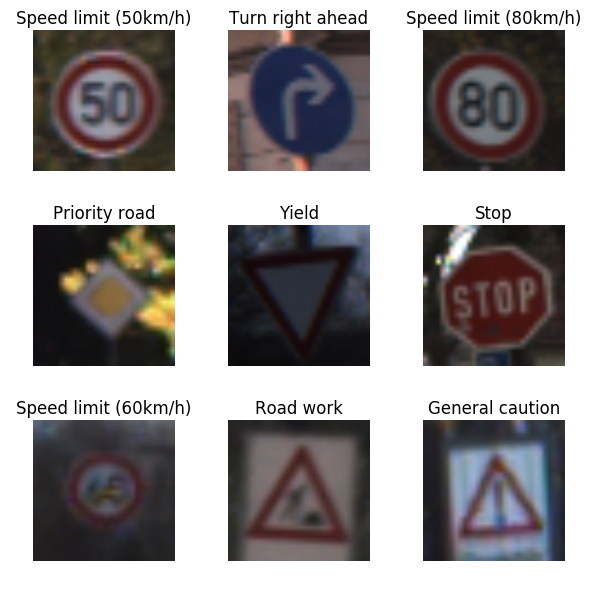

In [7]:
# draw random samples from training data

n_samples = 9
isample = np.random.randint(0, n_train, n_samples)
sample_imgs = X_train[isample]
sample_labels = list(map(label_descriptions.get, y_train[isample]))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(2*3, 2*3))
axes = axes.ravel()
fig.tight_layout()

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

*** Observation 1: it looks like the lighting condition in images are very different! Would it help to normalize the illumination of images?***

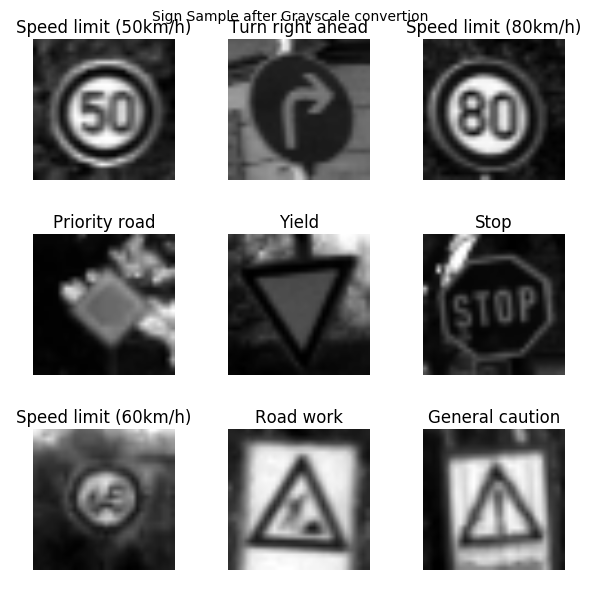

In [8]:
# draw random samples from training data, after convertion to grayscale
# gray scale looks better! - but are we throwing away too much infor on color?

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(2*3, 2*3))
axes = axes.ravel()
fig.suptitle("Sign Sample after Grayscale convertion", verticalalignment='bottom')
fig.tight_layout()

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    #ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap=plt.cm.gray)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0], cmap=plt.cm.gray)
    ax.set_title(label)
    ax.axis('off')

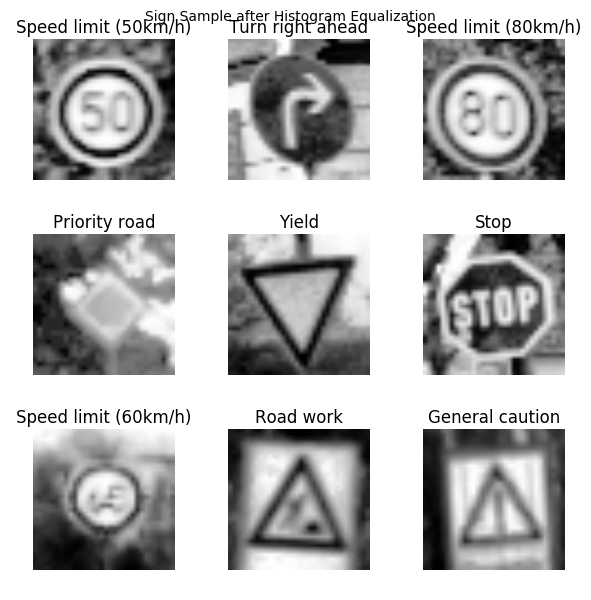

In [9]:
# However, goting further with a naive illumination equalization doesn't look to help too much

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(2*3, 2*3))
axes = axes.ravel()
fig.suptitle("Sign Sample after Histogram Equalization", verticalalignment='bottom')
fig.tight_layout()


for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]), cmap=plt.cm.gray)
    ax.set_title(label)
    ax.axis('off')

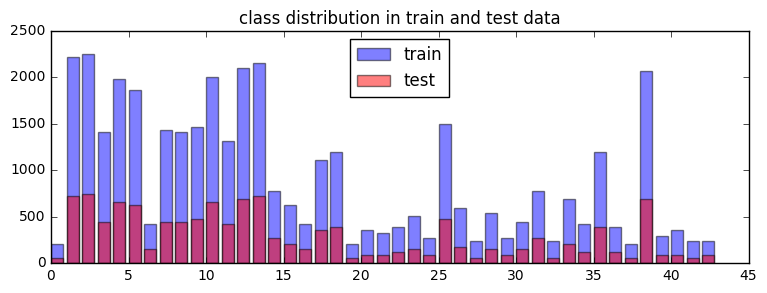

In [10]:
# now look at the distributions of classes in train and test
# 1. are the distributions skewed?
# 2. are the distributions in train and test similiar?

train_classes = np.bincount(y_train)
test_classes = np.bincount(y_test)
assert train_classes.shape[0] == test_classes.shape[0], "train and test data don't have same number of clases"
plt.figure(figsize=(9, 3))
plt.bar(range(n_classes), train_classes, label="train", color="b", alpha=0.5)
plt.bar(range(n_classes), test_classes, label="test", color="r", alpha=0.5)
plt.legend(loc="best")
plt.title("class distribution in train and test data")

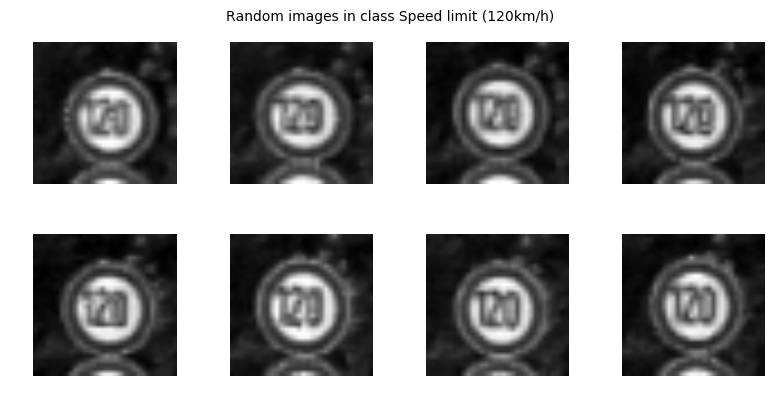

In [11]:
# How similiar are the images within one class
random_class = np.random.randint(0, n_classes)
random_imgs = X_train[(y_train==random_class)][:8]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(2*4, 2*2))
axes = axes.ravel()
fig.suptitle("Random images in class %s" % label_descriptions[random_class], verticalalignment='bottom')
fig.tight_layout()


for ax, img in zip(axes, random_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap = plt.cm.gray)
    ax.axis('off')

### Conclusion on Data Exploration
- It is good for many dark images to convert them to grayscale - using V channel of YUV as suggested in the [benchmark paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), even though we might have the risk of discarding color information that is useful for classification. But overally convertion to grayscale looks better, we need to test it out in modelling.
- The distributions of sign classes in train ad test are relatively similiar. The sign distributions are skewed - majority of them are within about 15 classes. This is similiar to other image dataset such as CIFAR, ImageNet. I don't see any big issue for now.
- As expected, the images within the same class are very similiar - the signs are essentially 2D, the only variations could be just illuminations, translations and backgrounds. This makes me wonder whether a nearest-neighbor classifier based on the "mean" of images is already a good baseline model.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Before going any further, I want to test with a cheap baseline first
- Use "mean" image as representative within a class
- Use nearest neighbor as classifier
- Result is 29.9% for training and 25.5% for testing, better than random guess: 1/43 = 2.3% :)
- Based on the inspection of baseline, I found the following "trouble-maker" signs:
    - Different cruves, e.g., "Dangerous curve to the right" misclassified vs "Dangerous curve to the left" vs "Double curve"
    - Different speed limits
    - Different crossing, e.g., "Bicycle crossing" vs "Wild Animial Crossing"
    - etc.
- That's what I expected because misclassified images look similiar! ***It looks like we are gonna have some fun!***

In [12]:
# average image based baseline model
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.preprocessing import MinMaxScaler

class NNClassifier(object):
    def __init__(self):
        self.classes = None
        self.vecs = None
        
    def fit(self, train_x, train_y):
        representative_vectors = []
        for cls in np.unique(train_y):
            vec = train_x[train_y == cls].mean(axis = 0)
            representative_vectors.append( (cls,vec) )
        classes, vecs = zip(*representative_vectors)
        self.classes = np.array(classes)
        self.vecs = np.array(vecs)
        return self
    
    def predict(self, test_x):
        if self.vecs is None:
            raise ValueError("Fit the model first")
        scores = cosine_distances(test_x, self.vecs)
        return self.classes[np.argmin(scores, axis = 1)]
    
    def score(self, test_x, test_y):
        yhat = self.predict(test_x)
        return np.mean(yhat == test_y)
    
    def classwise_score(self, test_x, test_y):
        import pandas as pd
        yhat = self.predict(test_x)
        result = []
        for cls in np.unique(test_y):
            i = (test_y == cls)
            result.append({
                    'class': label_descriptions[cls],
                    'accuracy': np.mean(yhat[i]==cls),
                    'top classfied as': label_descriptions[np.argmax(np.bincount(yhat[i]))],
                    'size': np.sum(i)
                })
        return pd.DataFrame(result).sort_values("accuracy")
    
# normalize data first
def to_grayscale(x):
    #nx = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).ravel() for img in x])
    nx = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0].ravel() for img in x])
    return nx


scaler = MinMaxScaler()
normalized_x_train = scaler.fit_transform(to_grayscale(X_train))
normalized_x_test  = scaler.transform(to_grayscale(X_test))

# test with baseline
baseline_model = NNClassifier().fit(normalized_x_train, y_train)
train_accuracy = baseline_model.score(normalized_x_train, y_train)
test_accuracy = baseline_model.score(normalized_x_test, y_test)
print("train accuracy of baseline:", train_accuracy)
print("test accuracy of baseline:", test_accuracy)

/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


train accuracy of baseline: 0.295365859879
test accuracy of baseline: 0.253840063341


*show what are the signs that can give us troubles*

In [13]:
from IPython.display import display
train_result = baseline_model.classwise_score(normalized_x_train, y_train)
test_result = baseline_model.classwise_score(normalized_x_test, y_test)
display(train_result.head(10))
display(test_result.head(10))

,accuracy,class,size,top classfied as
20,0.013889,Dangerous curve to the right,360,Dangerous curve to the left
8,0.037589,Speed limit (120km/h),1410,Speed limit (70km/h)
7,0.041667,Speed limit (100km/h),1440,Speed limit (70km/h)
5,0.047312,Speed limit (80km/h),1860,Speed limit (60km/h)
15,0.100000,No vechiles,630,Speed limit (60km/h)
1,0.104505,Speed limit (30km/h),2220,Speed limit (70km/h)
29,0.107407,Bicycles crossing,270,Wild animals crossing
42,0.141667,End of no passing by vechiles over 3.5 metric ...,240,End of no passing
23,0.145098,Slippery road,510,Dangerous curve to the left
21,0.160606,Double curve,330,Dangerous curve to the left


,accuracy,class,size,top classfied as
20,0.011111,Dangerous curve to the right,90,Dangerous curve to the left
40,0.011111,Roundabout mandatory,90,Speed limit (60km/h)
5,0.022222,Speed limit (80km/h),630,Speed limit (70km/h)
22,0.025000,Bumpy road,120,Traffic signals
7,0.040000,Speed limit (100km/h),450,Speed limit (60km/h)
23,0.046667,Slippery road,150,Dangerous curve to the left
8,0.053333,Speed limit (120km/h),450,Speed limit (60km/h)
28,0.053333,Children crossing,150,Dangerous curve to the left
32,0.066667,End of all speed and passing limits,60,End of no passing
18,0.069231,General caution,390,Wild animals crossing


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

1. Following the "30 samples" rule in the class, I separate 10K of the original training data as valiation set, and use the whole original test data for final testing. So ~30K original images will be used for training. Given the similarity of the images (see the exploration above), it should be enough for big sign classes. I will use image aurgmentation (random rotation and shift) to first boost performances for minor classes.

    I use the aurgmented training data to learn the model parameters, validation data to monitor overfitting and test data to get the final estimate of accuracy. 
    

2. Here I am following the paradigm of converting training data into a data generator, because
    - it is easier to support out-of-core training when the dataset becomes larger for memory
    - it is easier to plug preprocessing/augmentation code because all code is in one place
    - it can be potentially faster, if data generating is running on CPU whereas training models on GPU.
    

3. In detail, the preprocessing steps I am currently using are,
    - gray scale - using V of YUV channels
    - normalization of pixel ranges to [0, 1]



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
Please refer to the answer to question 1 above.

**some helper functions**

In [14]:
def plot_images(images, nrows, titles = None, plot_size=2, is_gray=False):
    ncols = int(np.ceil(images.shape[0] / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(plot_size*ncols, plot_size*nrows))
    fig.tight_layout()
    axes = axes.ravel()
    cmap = plt.cm.gray if is_gray else None
    titles = titles or [None] * images.shape[0]
    for img, ax, title in zip(images, axes, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        
import functools

def compose(functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions[::-1])

**train, valid, test data split**

In [15]:
# train, valid, test data split
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size = 10000)
test_x, test_y = X_test, y_test
print(train_x.shape, valid_x.shape, train_y.shape, valid_y.shape, test_x.shape, test_y.shape)
print( len(np.unique(train_y)), len(np.unique(valid_y)), len(np.unique(test_y)))

(29209, 32, 32, 3) (10000, 32, 32, 3) (29209,) (10000,) (12630, 32, 32, 3) (12630,)
43 43 43


** data generator with preprocessing pipeline and image augmentation **

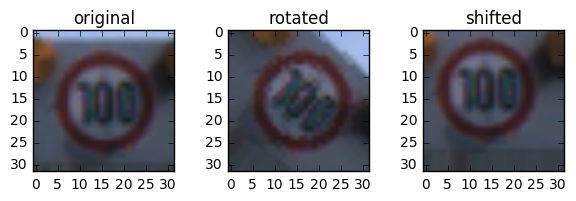

In [16]:
# image dataset augmentation
# borrow some code from Keras library https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py
import scipy.ndimage as ndi

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x

def random_rotation(img, degree=30):
    theta = np.pi / 180 * np.random.uniform(-degree, degree)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = img.shape[0], img.shape[1]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(img, transform_matrix, channel_index=2)
    return x

def random_shift(img, shiftw=0.15, shifth=0.15):
    h, w = img.shape[0], img.shape[1]
    tx = np.random.uniform(-shifth, shifth) * h
    ty = np.random.uniform(-shiftw, shiftw) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(img, transform_matrix, 2)
    return x

################# test image augmentations ##################
i = np.random.randint(0, train_x.shape[0])
images = {
    "original": train_x[i]
    , "rotated": random_rotation(train_x[i], 45)
    , "shifted": random_shift(train_x[i], 0.2, 0.2)
}
plot_images(np.array(list(images.values())), nrows=1, titles=images.keys())

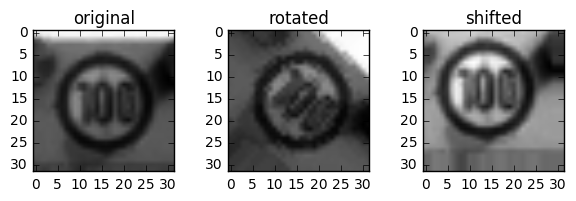

In [17]:
# preprocessing

def onehot_encode(labels, nb_classes=None):
    nb_classes = nb_classes or (np.max(labels) + 1)
    y = np.zeros((labels.shape[0], nb_classes))
    y[np.arange(labels.shape[0]), labels] = 1.
    return y.astype(np.float32)

def preprocess_grayscale(images):
    #return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0] for img in images])

def preprocess_yuv(images):
    #return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV) for img in images])

def preprocess_normalize(images):
    return images / 255.

def preprocess_expanddim(images):
    return np.expand_dims(images, axis=3)

def preprocess_tofloat32(images):
    return images.astype(np.float32)

################# test image preprocessing ##################
p = compose([preprocess_grayscale, preprocess_normalize])

plot_images(p(list(images.values())), nrows=1, titles=images.keys(), is_gray=True)

In [18]:
# data generator
from sklearn.utils import shuffle

def batch_geneator(xs, ys, batch_size=128, augmentation_methods=None, preprocess_steps=None):
    """Generate input, output batches based on data - it will loop forever
    
    - xs, ys: inputs (images) and outputs (labels)
    - batch_size: # of instances in a generated batch
    - augmentation_methods: list of tuple (method, factor), where method is used to generate new images 
      and factor is # of augmented images generated for each original. 
      e.g., [(random_rotation, 5), (random_shift, 10)]
    - preprocess_steps: list of methods to be applied to batch of images
    """
    assert xs.shape[0] == ys.shape[0], "inputs and outputs don't have matched size"
    n_samples = xs.shape[0]
    nb_classes = len(np.unique(ys))
    process = compose(preprocess_steps)
    
    x_pool, y_pool = [], []
    
    i = 0
    while True:
        i = i % n_samples
        img, label = xs[i], ys[i]
        x_pool.append(img)
        y_pool.append(label)
        for fn, num in augmentation_methods:
            for _ in range(num):
                x_pool.append(fn(img))
                y_pool.append(label)
        if len(x_pool) >= batch_size:
            x_batch = process(np.array(x_pool[:batch_size]))
            #x_batch = np.expand_dims(x_batch, axis=3)
            y_batch = onehot_encode(np.array(y_pool[:batch_size]), nb_classes=nb_classes)
            x_pool = x_pool[batch_size:]
            y_pool = y_pool[batch_size:]
            yield shuffle(x_batch, y_batch)
        i += 1

In [19]:
# test data generator
preprocess_steps = [preprocess_grayscale, preprocess_normalize, 
                   preprocess_expanddim, preprocess_tofloat32]
augmentation_methods=[(random_shift, 10), (random_rotation, 10)]

train_generator = batch_geneator(train_x, train_y, batch_size=64,
                                 augmentation_methods=augmentation_methods,
                                 preprocess_steps=preprocess_steps)
xs, ys = next(train_generator)
assert xs.shape[0] == ys.shape[0] == 64, "batch size test fails"
assert len(xs.shape) == 4 and xs.shape[-1] == 1, "grayscale test fails"
assert 0. <= xs.min() <= xs.max() <= 1., "normalization test fails"
assert ys.shape[1] == 43, "onehot encoding test fails"
assert xs.dtype==np.float32 and ys.dtype==np.float32, "dtype test fails"

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

*** 1. Architecture ***

- I am using a VGG-like CNN model, in detail it looks like:

    ```input_image -> one of several conv_block -> fully_connected_block -> output_logit```

- a `conv_block` is defined as one or several `convolutional layer` + `average/max pooling`. Each layer is also followed by a `RELU activation layer` and a `Dropout layer`. For details, please look up the `layers` variable defined below.

*** 2. Design Choices ***
- This architecture is inspired by the good performance of VGG-like CNN on other image classification tasks such as CIFAR and ImageNet.
- I have started with a minimal CNN and progressively add more convolutional layers to make it deeper for better performances. 
- Compared to original VGG, I have tried both max and avg pooling and in practice the avg_pooling gives slightly better performance.
- Dropout layers are widely used in such a deep model to avoid over-fitting. This forces the model to focus on image featres that are sparse and genearlize well.
- Recent research suggests that it is possible to replace the top fully-connected layers with convolutional layers to build a "pure convolutional network". One advantage of this is that the image inputs to the network don't have to be of the fixed size. I stick with the traditional FC head for simplicity.
- I have also considered using a pretrained VGG model for transfer learning. But it turned out that building it from the scratch for this simple dataset is a lot of fun!

*** 3. Implementations ***

I have tried to make the implementation flexible to experiement with different choices. In detail

- I have implemented `layers` as building block than using tensorflow variables directly. This makes it easier for me to change my network architecutre quickly.
- All preprocessing steps and data argumentation channels are implemented as pipelines. So different comibnations can be explored by plugging different pipes.
- Because I plan to run the optimization code on my GPU (GTX 980M with only 4G memory). I need to carefully batch my data to fit them into the GPU memory. So all training, validation and test data are generated on the runtime and fed to model in batches.

*** 4. Test driven ***
- There are a lot of test code scattered with the main function code. It helps me make sure everything is woking OK when I explore to change one thing at a time.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

When training my network, I found the following things crucial to achieving good results.

- Proper parameter initialization is key to make the network just work. I am using `tf.truncated_normal` for small random values - it breaks the symmetry at the beginning and won't be saturated. Because my network is relatively deep and there is no `batch normalization` in any layer, preventing nodes from being saturated is very important.
- There is a theoritical possibility that some "relu" nodes might be dead during the training when the activation moves to negative. More advanced activation functions e.g. leaky relu or maxout may help with the problem. But here I am just using "relu" for simplicty and use dropout with it, to hopefully alleviate the "dead neuron" issues.
- Using dropout is very important to prevent overfittings - I have seen previously that most images from the same class are very similiar to each. I don't want the network to spend a lot of parameters memorizing the exact pixels of each image.
- To squeeze the final bits of accuracy, I used data augrmentation to jitter images by randomly shifting or rotating them. The benefit are two-fold:
    - I am able to train a bigger/deeper model by using more "artificial" data
    - It helps with over-fitting as the model is now forced to consider translation and rotation invariance. 
    
Optimizes, batch size, epochs and hyperparameters:

- I am using ADAM as optimizer, pretty much like the de-facto nowadays
- I use a batch size of 128 - the main considertation is whether I can fit it in my GPU memory
- \# of epochs - the validation accuracy starts as 98% after only two epochs, because I used a lot of artificially generated images. It seems that any value larger than 5 will give good result.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I am not really sure what is being asked here. Literature research will usually give me a good start, and the rest is basically trial and error. There are some tricks that I have learned over my experiences.

1. start with simple models to make sure the implementation is easy to test.
2. start with a small sample of data to make sure my model has enough power to overfit the small sample.
3. follow software engineering principles to make the impelemntation open to extensions and close to modifications.

** Final results:**

```train accuracy = 1.00
validation accuracy = 1.00
test accuracy = 0.97```

#### Build CNN

In [25]:
# build convolution neural network with tensorflow
import tensorflow as tf
from tensorflow import Variable

# building blocks
def rand_tensor(shape):
    return Variable(tf.truncated_normal(shape, stddev=0.1))

def zero_tensor(shape):
    return Variable(tf.zeros(shape))

def conv2d(x, w, b, stride=1):
    """Convolution2D op with filter w
    """
    x = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding="SAME")
    x = tf.nn.bias_add(x, b)
    return x

def avgpool2d(x, k=2):
    """Average pooling op with kernel size = k and same stride
    """
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, k, k, 1], padding="SAME")

def maxpool2d(x, k=2):
    """Maximum pooling op with kernel size = k and same stride
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, k, k, 1], padding="SAME")

def fully_connected(x, w, b):
    x = tf.add(tf.matmul(x, w), b)
    return x

def relu(x):
    return tf.nn.relu(x)

def flatten(x):
    batch_shape = tf.pack([-1, tf.reduce_prod(tf.shape(x)[1:])])
    x = tf.reshape(x, batch_shape)
    return x

def dropout(x, p):
    return tf.nn.dropout(x, p)

# construct CNN based on layers and their parameters
def conv_net(x, layers):
    """Build a convolutional network out of input `x` and parameter variables
    """
    layer_constructors = {
        "conv": conv2d
        , "avgpool": avgpool2d
        , "maxpool": maxpool2d
        , "fc": fully_connected
        , "relu": relu
        , "flatten": flatten
        , "dropout": dropout
    }
    for name, param in layers:
        param.update({"x": x})
        x = layer_constructors[name](**param)
    return x

# using same probability for all dropout layers
n_colors = 1
keep_prob = tf.placeholder(tf.float32)
batch_images = tf.placeholder(tf.float32, [None, 32, 32, n_colors])
batch_labels = tf.placeholder(tf.float32, [None, n_classes])

# layer and parameters
layers = [ 
    # conv_pool block 1
     ("conv", {"w": rand_tensor([3, 3, n_colors, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("dropout", {"p": keep_prob})
    , ("conv", {"w": rand_tensor([3, 3, 64, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # conv_pool block 2
    , ("conv", {"w": rand_tensor([3, 3, 64, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # conv_pool block 3
    , ("conv", {"w": rand_tensor([3, 3, 64, 128]),
                "b": zero_tensor([128])})
    , ("relu", {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # flatten
    , ("flatten", {})
    
    # fully connected block 1
    ## after 2 pooling, the image size will become
    ## 32 / 2 / 2 / 2 = 4
    , ("fc", {"w": rand_tensor([4 * 4 * 128, 1024]),
              "b": zero_tensor([1024])})
    , ("relu", {})
    
    # fully connected block 2
    , ("fc", {"w": rand_tensor([1024, 1024]),
              "b": zero_tensor([1024])})
    , ("relu", {})
    
    # output layer
    , ("fc", {"w": rand_tensor([1024, n_classes]),
              "b": zero_tensor([n_classes])})
]

scores = conv_net(batch_images, layers)
probs = tf.nn.softmax(scores)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(scores, batch_labels))
match = tf.equal(tf.arg_max(scores, dimension=1), 
                 tf.arg_max(batch_labels, dimension=1))
accuracy = tf.reduce_mean(tf.cast(match, tf.float32))
optimize = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# save model
saver = tf.train.Saver()

#init = tf.initialize_all_variables()

# I need to evaluate accuracy of a large dataset
# by batch because it won't fit on my tiny GPU
def evaluate_on_batch(variable, session, x, y, batch_size=100):
    n_blocks = int(np.ceil(x.shape[0] / batch_size))
    evaluations, sizes = [], []
    for i in np.array_split(np.arange(x.shape[0]), n_blocks):
        batch_x, batch_y = x[i], y[i]
        val = session.run(variable, 
                     feed_dict={batch_images: batch_x,
                               batch_labels: batch_y,
                               keep_prob: 1.})
        evaluations.append(val)
        sizes.append(len(i))
    total = sum([val*sz for val, sz in zip(evaluations, sizes)])
    total /= sum(sizes)
    assert sum(sizes) == x.shape[0] == y.shape[0], "size don't match"
    #print(evaluations)
    return total



In [21]:
# data setup
from functools import partial
batch_size =128

# dataset augmentation: for each image
# generate nb_random_shift + nb_random_rotation images + 1 original
nb_random_shift = 5
nb_random_rotation = 5

# preprocessing steps
preprocess_steps = [preprocess_grayscale, preprocess_normalize, 
                   preprocess_expanddim, preprocess_tofloat32]
# preprocess_steps = [preprocess_yuv, preprocess_normalize, preprocess_tofloat32]
# pipe all preprocess steps into one function
p = compose(preprocess_steps)

augmentation_methods=[(partial(random_shift, shiftw=0.15, shifth=0.15), nb_random_shift), 
                      (partial(random_rotation, degree=20), nb_random_rotation)]
# train, valid and test data
train_generator = batch_geneator(train_x, train_y, batch_size=batch_size,
                                 augmentation_methods=augmentation_methods,
                                 preprocess_steps=preprocess_steps)
train_data = (p(train_x), onehot_encode(train_y, n_classes))
valid_data = (p(valid_x), onehot_encode(valid_y, n_classes))
test_data = (p(test_x), onehot_encode(test_y, n_classes))


In [26]:
# test the cnn model: 
# with random initialization, the predictions should be random
# so the accuracy of initial model should be 1 / n_classes
estimate = 1./n_classes
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    valid_accuracy = evaluate_on_batch(accuracy, sess, valid_data[0], valid_data[1])
    test_accuracy = evaluate_on_batch(accuracy, sess, test_data[0], test_data[1])
    print ("initial valid accuracy: %.3f should be close to 1/n_classes: %.3f" 
           % (valid_accuracy, estimate))
    print ("initial test accuracy: %.3f should be close to 1/n_classes: %.3f" 
           % (test_accuracy, estimate))

initial valid accuracy: 0.008 should be close to 1/n_classes: 0.023
initial test accuracy: 0.009 should be close to 1/n_classes: 0.023


#### Training

In [60]:
%%time

nb_epochs = 7
model_path = "models/model.ckpt"


nb_batches = train_x.shape[0] * (1 + nb_random_shift + nb_random_rotation) / batch_size
nb_batches = int(np.ceil(nb_batches))

# training and validation
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for epoch in range(nb_epochs):
        for b in range(nb_batches):
            x_batch, y_batch = next(train_generator)
            _, train_loss = sess.run([optimize, loss], 
                                     feed_dict={batch_images: x_batch,
                                           batch_labels: y_batch,
                                           keep_prob: 0.5})
            if b % 500 == 0:
                
                print("epoch %i batch %i: train_loss %.2f" 
                      % (epoch, b, train_loss))
                #train_accuracy = evaluate_on_batch(accuracy, sess, x_batch, y_batch)
                #print("train accuracy: ", train_accuracy)
                
        valid_accuracy = evaluate_on_batch(accuracy, sess, valid_data[0], valid_data[1])
        print("epoch %i, valid accuracy = %.2f" % (epoch, valid_accuracy))
    
    # evaluation on test data 
    test_accuracy = evaluate_on_batch(accuracy, sess, test_data[0], test_data[1])
    print("test accuracy = %.2f" % (test_accuracy, ))
    
    # save model checkpoint
    save_path = saver.save(sess, model_path)

epoch 0 batch 0: train_loss 14.58
epoch 0 batch 500: train_loss 3.15
epoch 0 batch 1000: train_loss 2.99
epoch 0 batch 1500: train_loss 0.82
epoch 0 batch 2000: train_loss 1.31
epoch 0 batch 2500: train_loss 0.37
epoch 0, valid accuracy = 0.88
epoch 1 batch 0: train_loss 0.86
epoch 1 batch 500: train_loss 0.29
epoch 1 batch 1000: train_loss 0.26
epoch 1 batch 1500: train_loss 0.24
epoch 1 batch 2000: train_loss 0.15
epoch 1 batch 2500: train_loss 0.24
epoch 1, valid accuracy = 0.98
epoch 2 batch 0: train_loss 0.28
epoch 2 batch 500: train_loss 0.22
epoch 2 batch 1000: train_loss 0.25
epoch 2 batch 1500: train_loss 0.05
epoch 2 batch 2000: train_loss 0.37
epoch 2 batch 2500: train_loss 0.14
epoch 2, valid accuracy = 0.99
epoch 3 batch 0: train_loss 0.12
epoch 3 batch 500: train_loss 0.21
epoch 3 batch 1000: train_loss 0.05
epoch 3 batch 1500: train_loss 0.05
epoch 3 batch 2000: train_loss 0.22
epoch 3 batch 2500: train_loss 0.09
epoch 3, valid accuracy = 1.00
epoch 4 batch 0: train_loss

In [27]:
# test saved model

model_path = "models/model.ckpt"
with tf.Session() as sess:
    saver.restore(sess, model_path)
    print("model has been restored from %s" % model_path)
    
    train_accuracy = evaluate_on_batch(accuracy, sess, train_data[0], train_data[1])
    print("train accuracy = %.2f" % (train_accuracy, ))
    
    valid_accuracy = evaluate_on_batch(accuracy, sess, valid_data[0], valid_data[1])
    print("validation accuracy = %.2f" % (valid_accuracy, ))
    
    test_accuracy = evaluate_on_batch(accuracy, sess, test_data[0], test_data[1])
    print("test accuracy = %.2f" % (test_accuracy, ))

model has been restored from models/model.ckpt
train accuracy = 1.00
validation accuracy = 1.00
test accuracy = 0.97


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

** To make it easier to test, first wrap the model prediction into a convinient function **

In [28]:
# wrap up the code into a classifier

class CNNSignClassifier(object):
    def __init__(self, model_path, signames_path):
        self.model_path = model_path
        self.signames = load_label_desc(signames_path)
    def preprocess(self, img):
        img = cv2.resize(img, (32, 32))
        x = p(np.array([img]))
        return x
    def predict(self, img):
        import pandas as pd
        x = self.preprocess(img)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, self.model_path)
            prob_vals = sess.run(probs, feed_dict={batch_images: x, keep_prob: 1.})[0]
        
        return pd.DataFrame(prob_vals, columns=["probs"],
            index=[self.signames[i] for i in range(prob_vals.shape[0])])

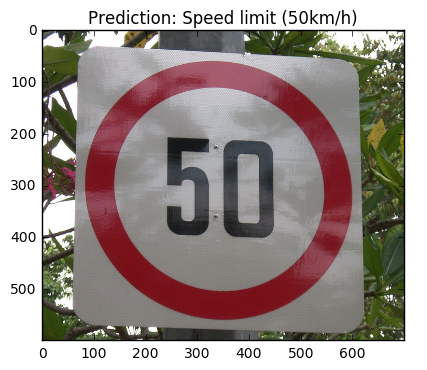

In [30]:
# test with an image

img = cv2.imread("test_images/limit50.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

sign_classifier = CNNSignClassifier("models/model.ckpt", "signnames.csv")
label_prediction = sign_classifier.predict(img)
plt.imshow(img)
plt.title("Prediction: " + label_prediction.idxmax()[0])

In [41]:
print("top 5 classification:")
label_prediction.sort_values(by="probs", ascending=False)[:5]

top 5 classification:


,probs
Speed limit (50km/h),0.983439
Speed limit (30km/h),0.011788
Speed limit (80km/h),0.004088
Speed limit (60km/h),0.000453
Keep right,0.000092


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.